#  ⚔️ The Final Showdown: SVM vs ResNet18
#
Qui mettiamo a confronto i due campioni.
Li testiamo su un dataset "Stressato" (Ruotato, Spostato, Luci diverse)
per vedere quale tecnologia è più robusta per l'industria.

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from torchvision import transforms
import pickle
from skimage.feature import hog
import cv2
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm

# --- 1. CONFIGURAZIONE ---

In [31]:
DATA_DIR = Path('../data/raw')
TEST_DIR = DATA_DIR / 'test'
RESULTS_DIR = Path('../results')
SVM_IMG_SIZE = (64, 64)
RESNET_IMG_SIZE = 224

In [32]:
# Configurazione Device
try:
    import torch_directml
    device = torch_directml.device()
except:
    device = torch.device("cpu")

# --- 2. DEFINIZIONE STRESS ---

In [33]:
# Questa pipeline "sporca" le immagini ogni volta in modo diverso
stress_transform = transforms.Compose([
    transforms.Resize((RESNET_IMG_SIZE, RESNET_IMG_SIZE)),
    transforms.RandomRotation(degrees=20),      # Rotazione +/- 20°
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Spostamento 10%
    transforms.ColorJitter(brightness=0.3),     # Cambio luce
])


# --- 3. CARICAMENTO MODELLI ---


In [34]:
# A) Carica SVM
print("⏳ Caricamento SVM...")
with open(RESULTS_DIR / 'svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# B) Carica ResNet
print("⏳ Caricamento ResNet18...")
from torchvision.models import resnet18
resnet_model = resnet18(weights=None)
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 2)
resnet_model.load_state_dict(torch.load(RESULTS_DIR / 'resnet18_best.pth', map_location=device))
resnet_model.to(device)
resnet_model.eval()
print("✅ Modelli caricati!")


⏳ Caricamento SVM...
⏳ Caricamento ResNet18...


C:\Users\rizzo\AppData\Local\Temp\ipykernel_25884\3774332099.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(RESULTS_DIR / 'resn

✅ Modelli caricati!


# --- 4. LOOP DI TEST ---

In [35]:
print("\n🔥 AVVIO BATTLE TEST SU TUTTO IL TEST SET 🔥")

true_labels = []
svm_preds = []
resnet_preds = []

# Trasformazione finale per ResNet (dopo lo stress)
resnet_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_files = list(TEST_DIR.glob('*/*.jpeg'))

for img_path in tqdm(test_files):
    # Label Reale
    label = 1 if 'def_front' in str(img_path) else 0
    true_labels.append(label)
    
    # Carica e Applica STRESS
    pil_img = Image.open(img_path).convert('RGB')
    stressed_img = stress_transform(pil_img) # L'immagine ora è "sporca"
    
    # --- PREDIZIONE SVM ---
    # 1. Converti in scala di grigi e resize a 64x64
    img_svm = stressed_img.convert('L').resize(SVM_IMG_SIZE)
    img_np = np.array(img_svm)
    
    # 2. Estrai HOG (Se hai usato HOG nel notebook 1)
    # Se hai usato RAW pixels nel notebook 1, usa: feat = img_np.flatten().reshape(1, -1)
    # Qui assumo tu stia usando la versione migliore (HOG)
    try:
        feat = hog(img_np, orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True)
        svm_p = svm_model.predict([feat])[0]
    except:
        # Fallback se hai salvato il modello "raw pixels"
        feat = img_np.flatten().reshape(1, -1)
        svm_p = svm_model.predict(feat)[0]
        
    svm_preds.append(svm_p)

    # --- PREDIZIONE RESNET ---
    img_tensor = resnet_norm(stressed_img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = resnet_model(img_tensor)
        _, res_p = torch.max(out, 1)
    resnet_preds.append(res_p.item())


🔥 AVVIO BATTLE TEST SU TUTTO IL TEST SET 🔥


100%|██████████| 715/715 [00:06<00:00, 108.65it/s]



# --- 5. GRAFICI FINALI ---


🏆 Final Comparison (Real Industrial Environment):
SVM Accuracy:    36.64%
ResNet Accuracy: 98.88%


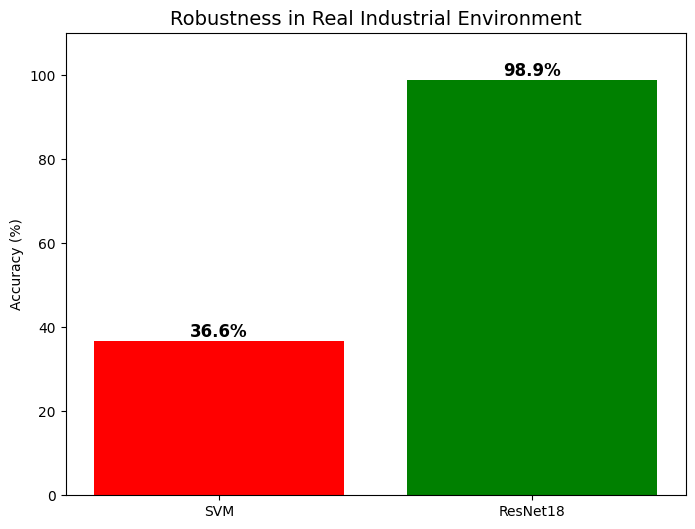

In [36]:
acc_svm = accuracy_score(true_labels, svm_preds) * 100
acc_res = accuracy_score(true_labels, resnet_preds) * 100

print(f"\n🏆 Final Comparison (Real Industrial Environment):")
print(f"SVM Accuracy:    {acc_svm:.2f}%")
print(f"ResNet Accuracy: {acc_res:.2f}%")

# Grafico a barre
plt.figure(figsize=(8, 6))
bars = plt.bar(['SVM', 'ResNet18'], [acc_svm, acc_res], color=['red', 'green'])
plt.title('Robustness in Real Industrial Environment', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)

# Aggiungi etichette sopra le barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', fontweight='bold', fontsize=12)

plt.savefig(RESULTS_DIR / 'final_comparison.png')
plt.show()